<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/MAPS_2_1_Cell_Detection_Azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MAPS Module 2.1 - Cell Detection with Azure**
This notebook will guide you through using your own Azure object detection model to perform cell detection and crop out individual cells from your images.
<br>
<br> 
Before you begin, follow this guide to create and train your own Azure model:  https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/get-started-build-detector
<br> 
<br>
Note: model training is code-free!
---

## Step 1: Install Azure Custom Vision SDK and other libraries

In [1]:
# install Azure SDK
!pip -q install azure-cognitiveservices-vision-customvision

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 


In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
# import Azure related libraries
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region

!!! Don't forget to also upload MAPS_util.py to this Colab session !!!

## Step 2: Setup your Azure trainer and predictor. Follow [this guide](https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/quickstarts/object-detection?tabs=visual-studio&pivots=programming-language-python) to locate the attributes

In [4]:
# Populate the following fields with attributes from your Custom Vision object detection project.

ENDPOINT = "your-endpoint" # ex: https://westus2.api.cognitive.microsoft.com/
training_key = "your-training_key"
prediction_key = "your-prediction_key"
#prediction_resource_id = "your-prediction-resource-id" # click on the resource's Overview tab, listed as Subscription ID

In [5]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

In [10]:
# list your projects
for project in trainer.get_projects():
  print(project.name, project.id)

PTEN_classification 1eae5342-91d5-4f2c-9848-9652c1e13b36
PTEN_obj_detect 852eead8-f80d-4645-9c3d-5ba1fa221df2


In [11]:
# copy the 'id' value of your object detection project and paste it below
project = trainer.get_project(project_id="your-project-id")
# if project is loaded successfully you should see it returned
project.id

'852eead8-f80d-4645-9c3d-5ba1fa221df2'

In [53]:
# list published iterations of your obj detection model
# iterations not published will print as "None"
for iter in trainer.get_iterations(project.id):
  if iter.publish_name == None:
    print(f'{iter.name}: not published')
  else:
    print(f'{iter.name} is published as "{iter.publish_name}"')

Iteration 7 is published as "Iteration7"
Iteration 6 is published as "Iteration6"
Iteration 4: not published
Iteration 3: not published


In [65]:
# specify the iteration you want to use (without spaces)
publish_iteration_name = "Iteration6"

## Step 3: Get the input images ready
We recommand uploading them as a zip file to Google Drive and follow the steps below to link the file to this VM. Alternatively, upload directly to this VM.

In [14]:
# It is recommended that you upload your source images as a zip file onto Google Drive.
# Then, the following cells will import  images for use in this session.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [133]:
# unzip
!unzip -q -d /content/ path-to-image-zip

## Step 4: Start Azure object detection

### (optional) convert TIF to JPEG

In [16]:
# (optional) convert TIF to JPEG
from PIL import Image
import glob

wrk_dir = 'your-image-directory' # replace with your image directory

for name in glob.glob(wrk_dir + '*.TIF'):
    im = Image.open(name)
    name = str(name).rstrip(".TIF")
    im.save(name + '.jpg', 'JPEG')

### Make predictions

Send images to Azure for predictions, and return a dataframe of predicted bounding boxes

In [2]:
img_dir = 'path-to-uncropped-images' # replace with your source image directory

In [ ]:
df_predict = pd.DataFrame(columns=['probability (%)', 'x', 'y', 'w', 'h', 'image_ID'])

for file in os.scandir(img_dir):
  x = []
  y = []
  w = []
  h = []
  prob = []
  if file.name.endswith('.jpg'):
    img_ID = file.name[:-4]
    # Open an image and get back the prediction results
    with open(img_dir+file.name, mode="rb") as img: #'r'-read, 'b'-binary (for images)
      results = predictor.detect_image(project.id, publish_iteration_name, img)
    # Display the results    
    for prediction in results.predictions:
      if prediction.probability > 0.4: # probability threshold = 60%
        prob.append(prediction.probability*100)
        x.append(prediction.bounding_box.left)
        y.append(prediction.bounding_box.top)
        w.append(prediction.bounding_box.width)
        h.append(prediction.bounding_box.height)
        
    df_temp = pd.DataFrame({'probability (%)': prob, \
                   'x': x, 'y': y, 'w': w, 'h': h})
    df_temp['image_ID'] = img_ID
    print(df_temp.head(), '\n')
    if df_temp.empty:
      continue
    else:
      df_predict = df_predict.append(df_temp, ignore_index=True)

In [135]:
print(f'total predicted ROIs: {len(df_predict)}', '\n')
df_predict.head()

total predicted ROIs: 337 



,probability (%),x,y,w,h,image_ID
0,79.555845,0.814568,0.500033,0.066248,0.077422,merged_191120100001_B02f115
1,77.382946,0.300991,0.281994,0.097191,0.086955,merged_191120100001_B02f115
2,57.142790,0.956477,0.533520,0.042734,0.069509,merged_191120100001_B02f115
3,49.363180,0.266083,0.870946,0.043427,0.038961,merged_191120100001_B02f115
4,48.588178,0.372517,0.156688,0.042214,0.038827,merged_191120100001_B02f115


In [136]:
# save bboxes df 
df_predict.to_csv('predicted_bboxes.csv', index=False)

# download the csv, or copy it to Google Drive
!cp predicted_bboxes.csv path-to-Google_Drive

### Inspect prediction results

In [4]:
from MAPS_util import plot_rectangles

merged_191120100001_B02f115


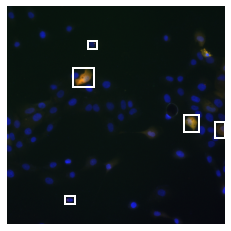

merged_191120100001_B02f129


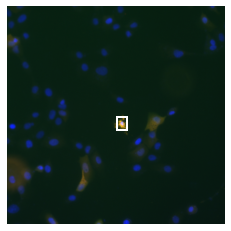

merged_191120100001_B02f59


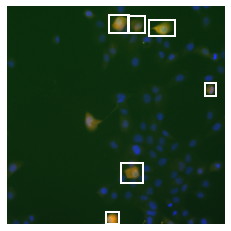

merged_191120100001_B02f215


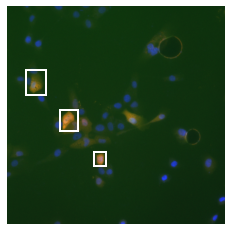

merged_191120100001_B02f46


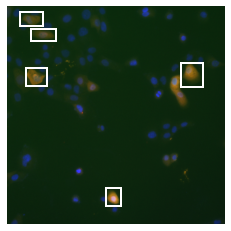

merged_191120100001_B02f114


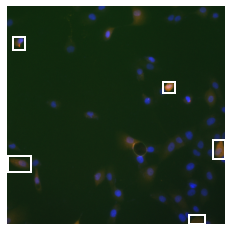

In [5]:
plot_interval = 20 # Will plot every 4th image with the bounding boxes

im_list = df_predict['image_ID'].unique()
for n, im_ID in enumerate(im_list):
  if n % plot_interval == 0:
    print(im_ID)
    image = cv2.imread(img_dir+im_ID+'.jpg')
    img_height, img_width, img_channel = image.shape
    # Retrieve all predicted bounding boxes for the current image
    bbox_df = df_predict.loc[df_predict['image_ID'] == im_ID].reset_index(drop=True)
    # Plot current image with predictedbboxes
    fig, ax = plot_rectangles(image, img_height, img_width, bbox_df)
    ax.set_axis_off()
    plt.show(); plt.close()

### Isolate ROIs, save them as individual images

In [6]:
# function to show cropped single cells
def imshow_ROIs(ROI_list):
  n = len(ROI_list)
  fig, axes = plt.subplots(1,n)
  if n > 1:
    for i, ax in enumerate(axes.ravel()):
      ax.imshow(ROI_list[i][:,:,::-1])
      ax.set_axis_off()
  elif n == 1:
      axes.imshow(ROI_list[0][:,:,::-1])
      axes.set_axis_off()
  plt.show(); plt.close()

In [7]:
# create a new folder to save cropped cells
!mkdir cropped_ROIs

current image: merged_191120100001_B02f115


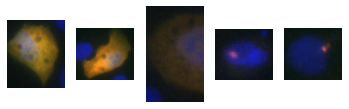

saved 5 ROIs 

current image: merged_191120100001_B02f17
saved 3 ROIs 

current image: merged_191120100001_B02f236
saved 1 ROIs 

current image: merged_191120100001_B02f220
saved 4 ROIs 

current image: merged_191120100001_B02f241


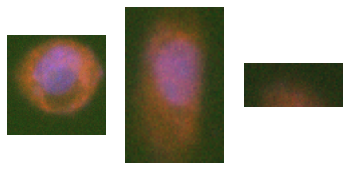

saved 3 ROIs 

current image: merged_191120100001_B02f60
saved 3 ROIs 

current image: merged_191120100001_B02f81
saved 4 ROIs 

current image: merged_191120100001_B02f127
saved 3 ROIs 

current image: merged_191120100001_B02f182


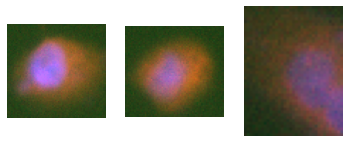

saved 3 ROIs 

current image: merged_191120100001_B02f64
saved 2 ROIs 

current image: merged_191120100001_B02f78
saved 5 ROIs 

current image: merged_191120100001_B02f50
saved 6 ROIs 

current image: merged_191120100001_B02f165


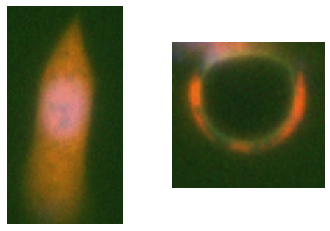

saved 2 ROIs 

current image: merged_191120100001_B02f221
saved 3 ROIs 

current image: merged_191120100001_B02f67
saved 6 ROIs 

current image: merged_191120100001_B02f18
saved 1 ROIs 

current image: merged_191120100001_B02f119


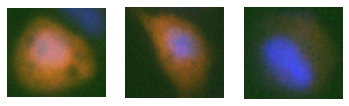

saved 3 ROIs 

current image: merged_191120100001_B02f121
saved 4 ROIs 

current image: merged_191120100001_B02f68
saved 2 ROIs 

current image: merged_191120100001_B02f162
saved 4 ROIs 

current image: merged_191120100001_B02f129


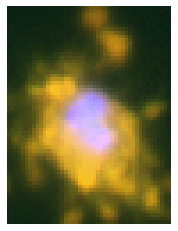

saved 1 ROIs 

current image: merged_191120100001_B02f12
saved 1 ROIs 

current image: merged_191120100001_B02f163
saved 5 ROIs 

current image: merged_191120100001_B02f183
saved 2 ROIs 

current image: merged_191120100001_B02f161


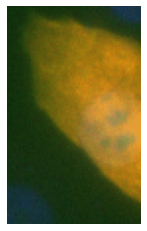

saved 1 ROIs 

current image: merged_191120100001_B02f73
saved 7 ROIs 

current image: merged_191120100001_B02f57
saved 3 ROIs 

current image: merged_191120100001_B02f214
saved 3 ROIs 

current image: merged_191120100001_B02f124


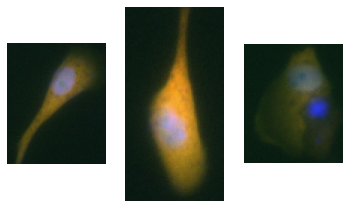

saved 3 ROIs 

current image: merged_191120100001_B02f27
saved 2 ROIs 

current image: merged_191120100001_B02f89
saved 6 ROIs 

current image: merged_191120100001_B02f189
saved 3 ROIs 

current image: merged_191120100001_B02f128


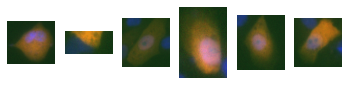

saved 6 ROIs 

current image: merged_191120100001_B02f86
saved 3 ROIs 

current image: merged_191120100001_B02f43
saved 3 ROIs 

current image: merged_191120100001_B02f160
saved 2 ROIs 

current image: merged_191120100001_B02f225


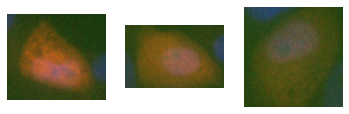

saved 3 ROIs 

current image: merged_191120100001_B02f54
saved 6 ROIs 

current image: merged_191120100001_B02f222
saved 4 ROIs 

current image: merged_191120100001_B02f120
saved 4 ROIs 

current image: merged_191120100001_B02f59


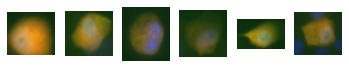

saved 6 ROIs 

current image: merged_191120100001_B02f37
saved 1 ROIs 

current image: merged_191120100001_B02f172
saved 1 ROIs 

current image: merged_191120100001_B02f20
saved 3 ROIs 

current image: merged_191120100001_B02f45


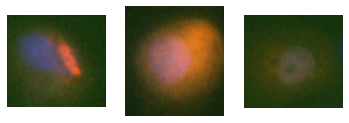

saved 3 ROIs 

current image: merged_191120100001_B02f175
saved 4 ROIs 

current image: merged_191120100001_B02f06
saved 1 ROIs 

current image: merged_191120100001_B02f30
saved 2 ROIs 

current image: merged_191120100001_B02f164


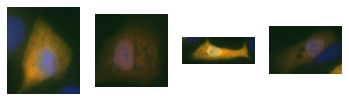

saved 4 ROIs 

current image: merged_191120100001_B02f70
saved 4 ROIs 

current image: merged_191120100001_B02f76
saved 1 ROIs 

current image: merged_191120100001_B02f74
saved 3 ROIs 

current image: merged_191120100001_B02f55


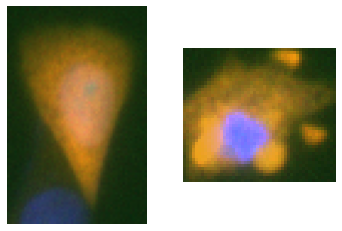

saved 2 ROIs 

current image: merged_191120100001_B02f49
saved 4 ROIs 

current image: merged_191120100001_B02f82
saved 2 ROIs 

current image: merged_191120100001_B02f08
saved 2 ROIs 

current image: merged_191120100001_B02f79


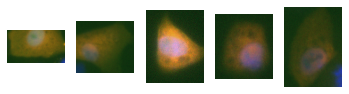

saved 5 ROIs 

current image: merged_191120100001_B02f87
saved 4 ROIs 

current image: merged_191120100001_B02f92
saved 1 ROIs 

current image: merged_191120100001_B02f96
saved 1 ROIs 

current image: merged_191120100001_B02f215


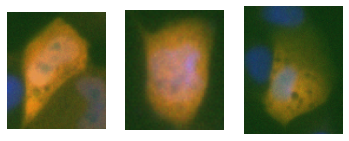

saved 3 ROIs 

current image: merged_191120100001_B02f42
saved 7 ROIs 

current image: merged_191120100001_B02f14
saved 2 ROIs 

current image: merged_191120100001_B02f80
saved 2 ROIs 

current image: merged_191120100001_B02f216


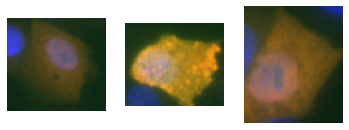

saved 3 ROIs 

current image: merged_191120100001_B02f217
saved 1 ROIs 

current image: merged_191120100001_B02f135
saved 5 ROIs 

current image: merged_191120100001_B02f28
saved 1 ROIs 

current image: merged_191120100001_B02f41


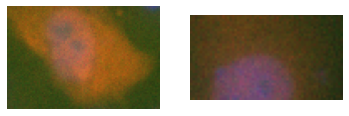

saved 2 ROIs 

current image: merged_191120100001_B02f185
saved 6 ROIs 

current image: merged_191120100001_B02f228
saved 6 ROIs 

current image: merged_191120100001_B02f52
saved 2 ROIs 

current image: merged_191120100001_B02f243


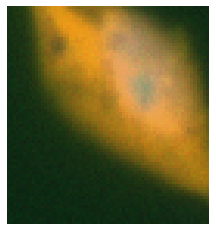

saved 1 ROIs 

current image: merged_191120100001_B02f158
saved 6 ROIs 

current image: merged_191120100001_B02f10
saved 3 ROIs 

current image: merged_191120100001_B02f113
saved 5 ROIs 

current image: merged_191120100001_B02f142


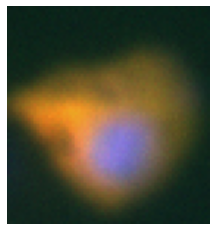

saved 1 ROIs 

current image: merged_191120100001_B02f117
saved 4 ROIs 

current image: merged_191120100001_B02f167
saved 2 ROIs 

current image: merged_191120100001_B02f85
saved 3 ROIs 

current image: merged_191120100001_B02f46


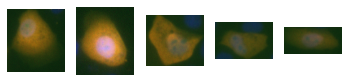

saved 5 ROIs 

current image: merged_191120100001_B02f75
saved 3 ROIs 

current image: merged_191120100001_B02f11
saved 1 ROIs 

current image: merged_191120100001_B02f103
saved 1 ROIs 

current image: merged_191120100001_B02f77


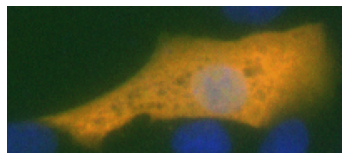

saved 1 ROIs 

current image: merged_191120100001_B02f238
saved 3 ROIs 

current image: merged_191120100001_B02f31
saved 3 ROIs 

current image: merged_191120100001_B02f83
saved 1 ROIs 

current image: merged_191120100001_B02f226


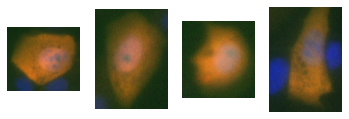

saved 4 ROIs 

current image: merged_191120100001_B02f132
saved 3 ROIs 

current image: merged_191120100001_B02f34
saved 3 ROIs 

current image: merged_191120100001_B02f25
saved 3 ROIs 

current image: merged_191120100001_B02f07


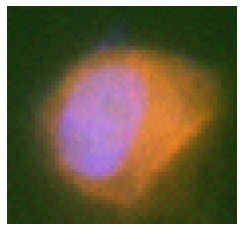

saved 1 ROIs 

current image: merged_191120100001_B02f47
saved 5 ROIs 

current image: merged_191120100001_B02f56
saved 2 ROIs 

current image: merged_191120100001_B02f106
saved 2 ROIs 

current image: merged_191120100001_B02f173


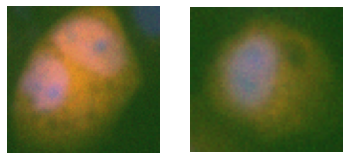

saved 2 ROIs 

current image: merged_191120100001_B02f04
saved 2 ROIs 

current image: merged_191120100001_B02f177
saved 1 ROIs 

current image: merged_191120100001_B02f171
saved 2 ROIs 

current image: merged_191120100001_B02f114


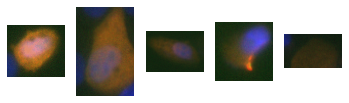

saved 5 ROIs 

current image: merged_191120100001_B02f224
saved 2 ROIs 

current image: merged_191120100001_B02f122
saved 2 ROIs 

current image: merged_191120100001_B02f118
saved 3 ROIs 

current image: merged_191120100001_B02f44


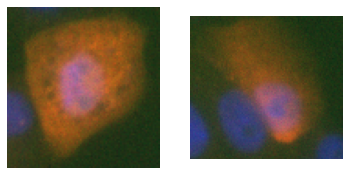

saved 2 ROIs 

current image: merged_191120100001_B02f169
saved 10 ROIs 

current image: merged_191120100001_B02f126
saved 5 ROIs 

current image: merged_191120100001_B02f21
saved 3 ROIs 

current image: merged_191120100001_B02f133


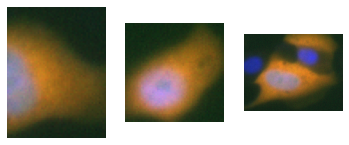

saved 3 ROIs 



In [8]:
# specify a destination folder
dst_dir = 'cropped_ROIs'

plot_interval = 4 # Will plot every 4th image with the bounding boxes

for i, image_ID in enumerate(df_predict['image_ID'].unique()):
  print(f'current image: {image_ID}')
  bbox_df = df_predict.loc[df_predict['image_ID'] == image_ID].reset_index(drop=True)
  image = cv2.imread(f'{img_dir}{image_ID}.jpg', -1)
  img_height, img_width, img_channel = image.shape
  
  # save each ROI as a separate image file
  detected_ROIs = []
  for j in range(len(bbox_df)):
    x = int(img_width * bbox_df.x[j])
    y = int(img_height * bbox_df.y[j])  
    w = int(img_width * bbox_df.w[j])
    h = int(img_height * bbox_df.h[j])

    ROI = image[y:y+h, x:x+w]
    cv2.imwrite(f'{dst_dir}{image_ID}_{j}.jpg', ROI)
    detected_ROIs.append(ROI)
  
  # plot ROIs to inspect at set plot_interval
  if i % plot_interval == 0:
    imshow_ROIs(detected_ROIs)
  print(f'saved {len(detected_ROIs)} ROIs', '\n')

In [9]:
# how many ROIs?
!ls cropped_ROIs/ | wc -l

337


In [ ]:
# zip the cropped ROIs
!zip -r R142W_cropped_ROIs.zip R142W_cropped_ROIs/

In [13]:
# download the zip file 
# or run this cell to copy it to Google Drive
!cp cropped_ROIs.zip path-to-Google_drive-folder